In [145]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from IPython import display

print('libraries imported ;p')

libraries imported ;p


$q_i = q_{i-1} + \alpha c_i \frac{\partial T}{\partial p}(p_{i-1})$ \
$p_i = p_{i-1} - \alpha d_i \frac{\partial V}{\partial q}(q_i)$ \
where $\alpha$ is the timestep and in this case $i$ denotes the generalized momentum and position at that timestep. Kinetic and potential energies of the system are given by: \
$T = \frac{1}{2}\sum_{i}M_i v_i^2$ ,   $V = \sum_{i} \sum_{j} \frac{(\delta_{ij}-1)G M_j}{2r_{ij}}$ \
\
where we divide the potential $V$ by $2$ because of double counting and $r_{ij} = |\mathbf{r_i} - \mathbf{r_j}|$. Let $p_i$ and $q_i$ now be the velocity and position of the $i^\text{th}$ body respectively. \
$\frac{\partial T}{\partial p_i} = M_i v_i$  ,   $\frac{\partial V}{\partial q_i} = \sum_{j}\frac{(1-\delta_{ij})GM_j}{r_{ij}^2}$ \
i.e. gradient of $V$ is the sum of gravitational forces from each body. \
\
Coefficients $c_i$ and $d_i$ are given by: \
$c_1 = \frac{1}{2 - 2^{1/3}}$
$c_2 = \frac{-2^{1/3}}{2 - 2^{1/3}}$
$c_3 = \frac{1}{2 - 2^{1/3}}$
$c_4 = 0$ \
$d_1 = \frac{1}{2(2- 2^{1/3})}$
$d_2 = \frac{1+2^{1/3}}{2(2- 2^{1/3})}$
$d_3 = \frac{1+2^{1/3}}{2(2- 2^{1/3})}$
$d_4 = \frac{1}{2(2- 2^{1/3})}$

In [124]:
#Masses = np.array()
cCoeffs = np.array([1/(2-np.cbrt(2)), -np.cbrt(2)/(2-np.cbrt(2)), 1/(2-np.cbrt(2)), 0])
dCoeffs = np.array([1/(2*(2-np.cbrt(2))),(1-np.cbrt(2))/(2*(2-np.cbrt(2))),(1-np.cbrt(2))/(2*(2-np.cbrt(2))),1/(2*(2-np.cbrt(2)))])

print(cCoeffs)
print(dCoeffs)
print(np.sum(cCoeffs))
print(np.sum(dCoeffs))

def createBodyArrays(debug=[]): #bodyShapeElements
    # Gets elements from Constant and body dicts and creates an array of elements to be added to bodiesDict
    SaturnElements = [ConstantsDict.get('SaturnElements')[0:6]]
    temp = BodiesDict.get('elements')
    temp = temp[:,0:6]
    BodyArray = np.concatenate((SaturnElements,temp))
    BodiesDict.update({'BodyArray': BodyArray})
    if 'bodyShapeElements' in debug:
        print(SaturnElements)
        print(np.shape(SaturnElements))
        print(np.shape(temp))
        print(np.shape(BodyArray))
    return None


def initParameters(mode): #WHAT IS A GOOD WAY TO PASS MANY PARAMETERS INTO AN INITIALIZATION FUNCTION??
    global ParamsDict
    ParamsDict = {

        'numberOfMoons': mode[0].count(1),
        'moonsList': mode[0],
        'moonsOrbitShape': mode[1],
        'moonsOrbitType': mode[2],
        'ringParticleNumber': mode[3],
        'initialDistributionType': mode[4],
        'ringLimits': mode[5]
    }
    return None

def initConstants(localMode):
    global ConstantsDict
    match localMode:
        case 'restricted':
            ConstantsDict = {
                'Gravitational Constant': 6.6726e-11,           #unreferenced
                'Saturn Mass': 5.6834e20,                       #from Horizon's Ephemeris, in gigagrams
                'Saturn Radius': 5.8232e1,                      #from Horizon's Ephemeris, in megameters
                'SaturnElements': np.array([ 1.95683334e-01, -2.07967708e-01,  8.89114822e-02,  1.00287582e-06,
        7.10261281e-07, -4.62358562e-07,  9.97617585e-07,  2.99078228e-01,
        2.48285806e-08]),
                'AegaeonElements': np.array([[ 1.62925749e+05,  2.62721373e+04, -2.95455149e+04,
        -3.33490571e+00,  1.31494109e+01, -6.56677155e+00,
         5.59234531e-01,  1.67654295e+05, -2.30249816e-02],
       [-2.38713706e+04,  1.47623071e+05, -7.50370575e+04,
        -1.48591023e+01, -1.34028152e+00,  2.14131733e+00,
         5.58089452e-01,  1.67311008e+05, -2.30249816e-02]]) #Aegaeon Elements to calculate ring angular momentum vector direction
            }
        case 'unrestricted':
            cCoeffs = np.array([1/(2-np.cbrt(2)), -np.cbrt(2)/(2-np.cbrt(2)), 1/(2-np.cbrt(2)), 0])
            dCoeffs = np.array([1/(2*(2-np.cbrt(2))),(1-np.cbrt(2))/(2*(2-np.cbrt(2))),(1-np.cbrt(2))/(2*(2-np.cbrt(2))),1/(2*(2-np.cbrt(2)))])
            ConstantsDict = {
                'Gravitational Constant': 6.6726e-11,           #unreferenced
                'Saturn Mass': 5.6834e20,                       #from Horizon's Ephemeris, in gigagrams
                'Saturn Radius': 5.8232e1,                      #from Horizon's Ephemeris, in megameters
                'SaturnElements': np.array([ 1.95683334e-01, -2.07967708e-01,  8.89114822e-02,  1.00287582e-06,
                7.10261281e-07, -4.62358562e-07,  9.97617585e-07,  2.99078228e-01,
                2.48285806e-08]),
                'AegaeonElements': np.array([[ 1.62925749e+05,  2.62721373e+04, -2.95455149e+04,
                -3.33490571e+00,  1.31494109e+01, -6.56677155e+00,
                 5.59234531e-01,  1.67654295e+05, -2.30249816e-02],
                [-2.38713706e+04,  1.47623071e+05, -7.50370575e+04,
                -1.48591023e+01, -1.34028152e+00,  2.14131733e+00,
                 5.58089452e-01,  1.67311008e+05, -2.30249816e-02]]), #Aegaeon Elements to calculate ring angular momentum vector direction
                'c Coefficients': cCoeffs,
                'd Coefficients': dCoeffs,
            }
    return None


def initBodiesDictionary(mode,debug=[]):
    global BodiesDict
    match mode:
        case 'circularMimas':
            BodiesDict = {
                'name': ['Mimas'],
                'mass': [3.75094e13],
                'semiMajorAxis': [186], #JPL Mean elements
                'elements': np.array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
        -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
         6.28360667e-04,  1.88377789e+02, -1.44997560e-04]]),
                'period': [81202.91773558],
            }
            circularizeMoonElements(debug)
            removeNetMomentum(debug) #Fill in later
        case 'circular':
            BodiesDict = {
                'name': ['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus'],
                'color': ['maroon', 'sienna', 'goldenrod', 'olivedrab', 'lightseagreen', 'darkblue', 'purple'],
                'mass': [3.75094e13, 1.080318e14, 6.174959e14, 1.0954868e15, 2.3064854e15, 1.345180354e17, 1.8056591e15], #unreferenced and also, masses are in gigagrams
                'semiMajorAxis1': [186, 238.4, 295, 377.7, 527.2, 1221.9, 3561.7], #JPL Mean elements
                'period': np.array([  81202.91773558,  118063.58844184,  162660.74331798,
        235823.79311927,  389307.62992529, 1373922.70607731,
       6835397.33903   ]),
                'elements': np.array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
        -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
         6.28360667e-04,  1.88377789e+02, -1.44997560e-04],
       [-2.37504674e+02,  4.38287375e+00,  2.07516961e+01,
         3.41979024e-04, -1.11706534e-02,  5.81982969e-03,
         7.95382958e-04,  2.38449812e+02, -3.94625721e-05],
       [-2.16465458e+02, -1.68425522e+02,  1.07915081e+02,
         7.61827803e-03, -7.81392642e-03,  3.11628009e-03,
         9.83138032e-04,  2.94737367e+02,  1.10750003e-05],
       [-1.78507630e+02, -2.87400621e+02,  1.67876593e+02,
         8.79997358e-03, -4.55139058e-03,  1.52685661e-03,
         1.25982456e-03,  3.77685903e+02, -1.71212616e-05],
       [-4.20266046e+02,  2.97492400e+02, -1.13714237e+02,
        -5.06391274e-03, -5.78324263e-03,  3.56885352e-03,
         1.75891800e-03,  5.27310350e+02,  3.58498357e-06],
       [-7.76758503e+02,  9.02355914e+02, -3.89577017e+02,
        -4.27821397e-03, -2.78299533e-03,  1.85622920e-03,
         4.17870777e-03,  1.25274507e+03,  7.08384752e-05],
       [-2.93445621e+03, -1.90942637e+03,  1.04088540e+03,
         1.82417062e-03, -2.59469624e-03,  2.47649163e-04,
         1.21832589e-02,  3.65244914e+03, -3.85475538e-05]])
            }
            circularizeMoonElements(debug)
            removeNetMomentum(debug) #Fill in later
        case 'elliptical':
            BodiesDict = {
                'name': ['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus'],
                'color': ['maroon', 'sienna', 'goldenrod', 'olivedrab', 'lightseagreen', 'darkblue', 'purple'],
                'mass': [3.75094e13, 1.080318e14, 6.174959e14, 1.0954868e15, 2.3064854e15, 1.345180354e17, 1.8056591e15], #unreferenced and also, masses are in gigagrams
                'period': np.array([  81202.91773558,  118063.58844184,  162660.74331798,
                    235823.79311927,  389307.62992529, 1373922.70607731,
                    6835397.33903   ]),
                'elements': np.array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
                    -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
                    6.28360667e-04,  1.88377789e+02, -1.44997560e-04],
                    [-2.37504674e+02,  4.38287375e+00,  2.07516961e+01,
                    3.41979024e-04, -1.11706534e-02,  5.81982969e-03,
                    7.95382958e-04,  2.38449812e+02, -3.94625721e-05],
                    [-2.16465458e+02, -1.68425522e+02,  1.07915081e+02,
                    7.61827803e-03, -7.81392642e-03,  3.11628009e-03,
                    9.83138032e-04,  2.94737367e+02,  1.10750003e-05],
                    [-1.78507630e+02, -2.87400621e+02,  1.67876593e+02,
                    8.79997358e-03, -4.55139058e-03,  1.52685661e-03,
                    1.25982456e-03,  3.77685903e+02, -1.71212616e-05],
                    [-4.20266046e+02,  2.97492400e+02, -1.13714237e+02,
                    -5.06391274e-03, -5.78324263e-03,  3.56885352e-03,
                    1.75891800e-03,  5.27310350e+02,  3.58498357e-06],
                    [-7.76758503e+02,  9.02355914e+02, -3.89577017e+02,
                    -4.27821397e-03, -2.78299533e-03,  1.85622920e-03,
                    4.17870777e-03,  1.25274507e+03,  7.08384752e-05],
                    [-2.93445621e+03, -1.90942637e+03,  1.04088540e+03,
                    1.82417062e-03, -2.59469624e-03,  2.47649163e-04,
                    1.21832589e-02,  3.65244914e+03, -3.85475538e-05]])#Horizons System Ephemeris Data for 2000-01-01
                }
    return None

def initOrbitType(mode,debug=[]): #updates dicts to accommodate restricted orbit type
    match mode:
        case 'restricted':
            elements = BodiesDict.get('elements')
            moonInclinations = np.array([])
            moonTrueAnomalies = np.array([])
            moonNodes = np.zeros((0,3))
            for i in range(len(elements)):
                pos = elements[i][0:3]
                vel = elements[i][3:6]
                normal = np.cross(pos,vel)
                angle = np.arccos(np.dot(normal, [0,0,1])/np.sqrt(np.dot(normal,normal)))
                moonInclinations = np.append(moonInclinations, angle)
                node = np.cross([0,0,1],normal)
                node = node/np.sqrt(np.dot(node,node))
                node = np.array([node])
                moonNodes = np.append(moonNodes,node,0)
                rotationMatrix = rotation_matrix(node[0], -angle)
                inPlanePos = np.matmul(rotationMatrix, pos)
                #print(inPlanePos)
                trueAnomaly = np.arctan2(inPlanePos[1],inPlanePos[0])
                moonTrueAnomalies = np.append(moonTrueAnomalies, trueAnomaly)
            if 'moonNodesAngles' in debug:
                print(moonInclinations)
                print(np.shape(moonNodes))
                print('node vectors: {}'.format(moonNodes))
                print('true anomaly angles: {}'.format(moonTrueAnomalies))
            BodiesDict.update({'moonNodes': moonNodes,'moonInclinations': moonInclinations,'moonTrueAnomalies': moonTrueAnomalies}) #moon orbit inclination, node, and true anomalies at time 0 added
        case 'unrestricted':
            createBodyArrays(debug)
    return None

def init(mode, debug=[]):
# pass list of moons to initialization, circular/elliptical, restricted/unrestricted
    initParameters(mode)
    initConstants(mode[2])
    initBodiesDictionary(mode[1],debug)#'elementDiff'
    initOrbitType(mode[2],debug)#'moonNodesAngles'
    return None #RingRArray, RingVArray

def accMatr(inRNBodyArray, masses):
    dim = len(inRNBodyArray)
    DistMatr = np.tile(inRNBodyArray,(dim,1,1))
    DistMatr = DistMatr - np.swapaxes(DistMatr,0,1)
    invSqrDist = DistMatr**2
    invSqrDist = np.sum(invSqrDist,axis=-1) ** (3/2)
    invSqrDist = np.reciprocal(invSqrDist,where= invSqrDist!=0)
    OutANBodyMatr = DistMatr * invSqrDist[...,None]

    masses1 = masses[...,None]
    OutANBodyMatr = OutANBodyMatr * masses1
    OutANBodyMatr = np.sum(OutANBodyMatr, axis=0)
    #OutANBodyMatr = OutANBodyMatr * gravConst *1e-12
    return OutANBodyMatr

init(([1,1,1,1,1,1,1], 'elliptical', 'unrestricted', 200, 'flatRadial', [84.77, 150.7022312, 20]), debug=['init','out'])

def ODESolve(mode):
    match mode:
        case 'solveSymp':
            gravConst = ConstantsDict.get('Gravitational Constant')
            saturnMass = ConstantsDict.get('Saturn Mass')
            periods = BodiesDict.get('period')
            trueAnomalies = BodiesDict.get('moonTrueAnomalies')
            moonInclinations = BodiesDict.get('moonInclinations')
            moonNodes = BodiesDict.get('moonNodes')
            moonMasses = BodiesDict.get('mass')
            radii = BodiesDict.get('radii')
            numberOfMoons = ParamsDict.get('numberOfMoons')
            ringParticleNumber = ParamsDict.get('ringParticleNumber')
            constants0 = (gravConst, saturnMass, moonMasses)

            snapshotIndices = np.linspace(t0,tf,snapshotNumber,endpoint=False)
            print(snapshotIndices)
            snapshotIndices = np.round(snapshotIndices/dt)
            snRingRArray = np.zeros((snapshotNumber,3))

            #snapshot arrays
            snRingRArray = np.zeros((snapshotNumber,3,ringParticleNumber))
            snRingVArray = np.zeros((snapshotNumber,3,ringParticleNumber))
            snSaturnArray = np.zeros((snapshotNumber,1,3))
            snMoonsArray = np.zeros((snapshotNumber,numberOfMoons,3))

            print(snapshotIndices)
            print('total steps: {}'.format(steps))
            s = 0 #snapshot index
            t = tList[0]

            for i in range(steps):
                if i % (int(steps/20)) == 0 and 'progress' in debug:
                    n = int(round(i / steps, 2) * 100)
                    print('{} % complete'.format(n))
                if s>=0:
                    if snapshotIndices[s] <= i:
                        moonPositions, saturnPosition = calcBodyPositions(t)
                        snRingRArray[s] = RingRArray
                        snRingVArray[s] = RingVArray
                        snSaturnArray[s] = saturnPosition
                        snMoonsArray[s] = moonPositions
                        print('snapshot #{} taken & test element {}'.format(s,snRingRArray[s][0,0]))
                        if s != snapshotNumber-1:
                            s += 1
                        else:
                            s = -100

                w0 = d2t_r(t, RingRArray,constants0)   #u is position, v is velocity, and w is acceleration
                u1 = RingRArray + dt*RingVArray/2
                v1 = RingVArray + dt*w0/2
                w1 = d2t_r(t + dt/2, u1,constants0)
                u2 = RingRArray + dt*v1/2
                v2 = RingVArray + dt*w1/2
                w2 = d2t_r(t + dt/2, u2,constants0)
                u3 = RingRArray + dt*v2
                v3 = RingVArray + dt*w2
                w3 = d2t_r(t + dt, u3,constants0)

                RingRArray = RingRArray + dt*(RingVArray+ 2*v1 + 2*v2 + v3) / 6
                RingVArray = RingVArray + dt*(w0 + 2*w1 + 2*w2 + w3) / 6
                t = tList[i+1] 
            return RingRArray, snRingRArray, snRingVArray, snSaturnArray, snMoonsArray, tList, snapshotIndices #ADD RETURN RingVArray

print(BodyMasses)
            print(BodyRArray)
            print(BodyVArray)

print(BodiesDict)

[ 1.35120719 -1.70241438  1.35120719  0.        ]
[ 0.6756036 -0.1756036 -0.1756036  0.6756036]
1.0
1.0
{'name': ['Mimas', 'Enceladus', 'Tethys', 'Dione', 'Rhea', 'Titan', 'Iapetus'], 'color': ['maroon', 'sienna', 'goldenrod', 'olivedrab', 'lightseagreen', 'darkblue', 'purple'], 'mass': [37509400000000.0, 108031800000000.0, 617495900000000.0, 1095486800000000.0, 2306485400000000.0, 1.345180354e+17, 1805659100000000.0], 'period': array([  81202.91773558,  118063.58844184,  162660.74331798,
        235823.79311927,  389307.62992529, 1373922.70607731,
       6835397.33903   ]), 'elements': array([[-1.12774495e+02,  1.37769404e+02, -6.15442605e+01,
        -1.11522197e-02, -7.32502779e-03,  4.48190526e-03,
         6.28360667e-04,  1.88377789e+02, -1.44997560e-04],
       [-2.37504674e+02,  4.38287375e+00,  2.07516961e+01,
         3.41979024e-04, -1.11706534e-02,  5.81982969e-03,
         7.95382958e-04,  2.38449812e+02, -3.94625721e-05],
       [-2.16465458e+02, -1.68425522e+02,  1.07915

In [3]:
x0 = np.array([
    [-1,1,0],
    [1,0,0],
    [-1,-1,0]
])

m0 = np.array([1,1,1])
x0 = np.float64(x0)
y0 = np.float64(y0)
dim = len(x0)
x1 = np.tile(x0,(dim,1,1))
x1 = x1 - np.swapaxes(x1,0,1)
print('kek: \n{} \n w'.format(x1))
x2 = x1 **2
#print(x2)
x2 = np.sum(x2,axis=-1) ** (3/2)
#print(x2)
x2 = np.reciprocal(x2,where= x2!=0)
print(x2)
x4 = x2[...,None] * x1
print(np.shape(x4))
print('unmassed \n {} \n'.format(x4))

m1 = m0[...,None]
m2 = m0[...,None, None]
#m1 = np.repeat(m0[:,np.newaxis],3,axis=-1)
print(np.shape(m1))
print(m1)
print(np.shape(m2))


a0 = x4 * m1 * m2
print(a0)
print(np.shape(a0))

kek: 
[[[ 0.  0.  0.]
  [ 2. -1.  0.]
  [ 0. -2.  0.]]

 [[-2.  1.  0.]
  [ 0.  0.  0.]
  [-2. -1.  0.]]

 [[ 0.  2.  0.]
  [ 2.  1.  0.]
  [ 0.  0.  0.]]] 
 w
[[0.         0.08944272 0.125     ]
 [0.08944272 0.         0.08944272]
 [0.125      0.08944272 0.        ]]
(3, 3, 3)
unmassed 
 [[[ 0.          0.          0.        ]
  [ 0.17888544 -0.08944272  0.        ]
  [ 0.         -0.25        0.        ]]

 [[-0.17888544  0.08944272  0.        ]
  [ 0.          0.          0.        ]
  [-0.17888544 -0.08944272  0.        ]]

 [[ 0.          0.25        0.        ]
  [ 0.17888544  0.08944272  0.        ]
  [ 0.          0.          0.        ]]] 

(3, 1)
[[1]
 [1]
 [1]]
(3, 1, 1)
[[[ 0.          0.          0.        ]
  [ 0.17888544 -0.08944272  0.        ]
  [ 0.         -0.25        0.        ]]

 [[-0.17888544  0.08944272  0.        ]
  [ 0.          0.          0.        ]
  [-0.17888544 -0.08944272  0.        ]]

 [[ 0.          0.25        0.        ]
  [ 0.17888544  0.0894427

In [14]:
x0 = np.array([
    [-1,0,0],
    [1,0,0]
])
y0 = np.array([
    [0,2,0]
])
m0 = np.array([1,1])
x0 = np.float64(x0)
y0 = np.float64(y0)
dim = len(x0)

x1 = x0[None,...] - y0[:,None,:]
x2 = x1 **2
x2 = np.sum(x2,axis=-1) ** (3/2)
x2 = np.reciprocal(x2,where= x2!=0)
print('x2 shape: {}'.format(np.shape(x2)))
x4 = x2[...,None] * x1 * m0[...,None]
print('x1 shape: {}'.format(np.shape(x1)))
print(np.shape(x4))
print('unmassed \n {} \n'.format(x4))
a0 = np.sum(x4, axis=1)
print(a0)

def accRings(inRNBodyArray, inRingRArray, masses):
    DistMatr = inRNBodyArray[None,...] - inRingRArray[:,None,:]
    invSqrDist = DistMatr**2
    invSqrDist = np.sum(invSqrDist,axis=-1) ** (3/2)
    invSqrDist = np.reciprocal(invSqrDist,where= invSqrDist!=0)
    OutRingAArray = invSqrDist[...,None] * DistMatr * masses[...,None]
    OutRingAArray = np.sum(OutRingAArray, axis=1)
    '''
    DistMatr = np.tile(inRNBodyArray,(dim,1,1))
    DistMatr = DistMatr - np.swapaxes(DistMatr,0,1)
    invSqrDist = DistMatr**2
    invSqrDist = np.sum(invSqrDist,axis=-1) ** (3/2)
    invSqrDist = np.reciprocal(invSqrDist,where= invSqrDist!=0)
    OutANBodyMatr = DistMatr * invSqrDist[...,None]

    masses1 = masses[...,None]
    OutANBodyMatr = OutANBodyMatr * masses1
    OutANBodyMatr = np.sum(OutANBodyMatr, axis=0)
    '''
    #OutANBodyMatr = OutANBodyMatr * gravConst *1e-12
    return OutRingAArray
'''
x1 = x1 - np.swapaxes(x1,0,1)
print('kek: \n{} \n w'.format(x1))
x2 = x1 **2
#print(x2)
x2 = np.sum(x2,axis=-1) ** (3/2)
#print(x2)
x2 = np.reciprocal(x2,where= x2!=0)
print(x2)
x4 = x2[...,None] * x1 
print(np.shape(x4))
print('unmassed \n {} \n'.format(x4))

m1 = m0[...,None]
m2 = m0[...,None, None]
#m1 = np.repeat(m0[:,np.newaxis],3,axis=-1)
print(np.shape(m1))
print(m1)
print(np.shape(m2))


a0 = x4 * m1 * m2
print(a0)
print(np.shape(a0))
'''

x2 shape: (1, 2)
x1 shape: (1, 2, 3)
(1, 2, 3)
unmassed 
 [[[-0.08944272 -0.17888544  0.        ]
  [ 0.08944272 -0.17888544  0.        ]]] 

[[ 0.         -0.35777088  0.        ]]


"\nx1 = x1 - np.swapaxes(x1,0,1)\nprint('kek: \n{} \n w'.format(x1))\nx2 = x1 **2\n#print(x2)\nx2 = np.sum(x2,axis=-1) ** (3/2)\n#print(x2)\nx2 = np.reciprocal(x2,where= x2!=0)\nprint(x2)\nx4 = x2[...,None] * x1 \nprint(np.shape(x4))\nprint('unmassed \n {} \n'.format(x4))\n\nm1 = m0[...,None]\nm2 = m0[...,None, None]\n#m1 = np.repeat(m0[:,np.newaxis],3,axis=-1)\nprint(np.shape(m1))\nprint(m1)\nprint(np.shape(m2))\n\n\na0 = x4 * m1 * m2\nprint(a0)\nprint(np.shape(a0))\n"

In [59]:
np.random.seed(1234)
genLimits = np.array([60.3, 185.5]) #goes in constants dict
def flatRadialPDF(x):
    #genLimits = ConstantsDict.get('Generation Limits')
    norm = 1 / (np.pi*(genLimits[1]**2 - genLimits[0]**2))
    out = norm* 2* np.pi*(np.heaviside((x-genLimits[0]),0) - np.heaviside((x-genLimits[1]),0))* x
    return out

def flatRadialCDF(x):
    #genLimits = ConstantsDict.get('Generation Limits')
    norm = 1 / (np.pi*(genLimits[1]**2 - genLimits[0]**2))
    out = norm* np.pi*(np.heaviside((x-genLimits[0]),0)*(x**2 -genLimits[0]**2) - np.heaviside((x-genLimits[1]),0)*(x**2 -genLimits[1]**2))
    return out

1.0000001863305363


C:\Users\Kenneth\AppData\Local\Temp\ipykernel_17784\3737524081.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  xr1 = xr0 - f(xr0)/df(xr0)


20000
185.497938051391


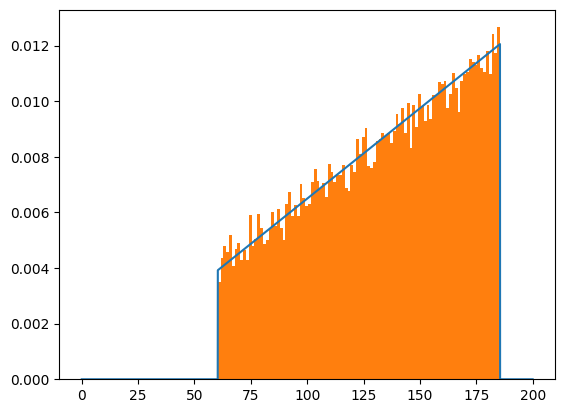

In [125]:

n = 1000000
genLimits = np.array([60.3, 185.5]) #goes in constants dict
x = np.linspace(0,200,n)
dt = 200/n
y0 = flatRadialPDF(x)
plt.plot(x,y0)
print(np.sum(y0)*dt)
y1 = flatRadialCDF(x)
#plt.plot(x,y1)


def NewtonRaphsonFlatRadial(f, df, x0, tolerance):
    '''
       finds a root of the equation f(x)=0, df is the derivative of f.
       The function should stops iterating when 
       
            | x_{i+1} - x_{i} | < tolerance
            
        and return an array with all the x_i values.
        
        x_0 is the starting point.         
    '''
    # YOUR CODE HERE
    genLimits = np.array([60.3, 185.5])
    #genLimits = ConstantsDict.get('Generation Limits')
    output = np.array([])
    xr0 = x0
    xr1 = xr0 - f(xr0)/df(xr0)
    output = np.append(output,[xr0,xr1])
    while abs(xr1 - xr0) > tolerance:
        xr0 = xr1
        xr1 = xr0 - f(xr0)/df(xr0)
        if xr1 > genLimits[1]:
            xr1 = genLimits[1]
        elif xr1 < genLimits[0]:
            xr1 = genLimits[0]
        output = np.append(output,xr1)
    return output

#np.random.seed(1234)
numberOfPoints = 20000
x = np.zeros(numberOfPoints)
for i in range(numberOfPoints):
    random = np.random.random()
    def flatRadialCDFshifted(input):
        return flatRadialCDF(input) - random
    root = NewtonRaphsonFlatRadial(flatRadialCDFshifted, flatRadialPDF, 125, 1e-6)
    root = root[-1]
    x[i] = root
print(len(x))
plt.hist(x,bins=100,density=True)
print(np.max(x))

In [ ]:
x0 = np.random.uniform(0,2*np.pi,size=(10000))
plt.hist(x0, density=True)

In [150]:
x0 = np.array([-100,-10,-1,1,10,100])
print(x0[(x0 > 10) | (x0 < -10)])

mx = np.ma.masked_outside(x0, -10, 10)
print('nomask x0: {}'.format(x0))
print('masked x0/mx: {}'.format(mx))
''''
1. calculate radii
2. create mask
3. apply mask to position and velocity arrays #this propagates the mask forward intrinsically
4. save mask

?? do this every step of integration or only for snapshots??

'''
y0 = np.array([-3,-2,-1,1,2,3])
#note: y0 is not masked but becomes masked when combined with a masked array
y1 = mx + y0
print('y1: {}'.format(y1))
y2 = y1
#y2.mask = np.ma.nomask
print(repr(y1))
print(repr(y2))
print('y2: {}'.format(y2)) #note: masked values retain the values they had until unmasked
#print(mx.mask)
#mx.mask = np.ma.nomask
#print(mx)
print('mx compressed: {}'.format(mx.compressed()))
print('y1 compressed: {}'.format(y1.compressed()))

mask = y1.mask
mask = np.bool_(np.ones((1,3)) * mask[...,None])
print(np.shape(mask))
print(mask)
plt.figure()
plt.plot(mx.compressed(),y1.compressed())
plt.figure()
plt.plot(mx.data,y1.data)

z0 = np.ma.masked_array([np.ones((6,3)),np.zeros((6,3))])
print(z0)
z0[0] = np.ma.masked_array(z0[0],mask = mask)
print('z0: \n{}'.format(z0))
print('z0 mask: \n{}'.format(z0.mask))
display.clear_output()
plt.close('all')

In [144]:
x0 = ~np.bool_([1, 0, 1])
print(x0)
y0 = np.array([['a', 'b', 'c'],['d','e','f'],['g','h','i']])
#y1 = np.ma.masked_array(y0, mask=x0[...,None])
#print(y1.compressed())

x1 = np.bool_([1, 0, 1])
z0 = y0[x1]
print(y0[x1])

x0 = np.arange(1,10)
print(x0)
print(x0[3:6])
x0[3:6] = np.array([-4,-5,-6])
print(x0)

[False  True False]
[['a' 'b' 'c']
 ['g' 'h' 'i']]
[1 2 3 4 5 6 7 8 9]
[4 5 6]
[ 1  2  3 -4 -5 -6  7  8  9]
